In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [2]:
from datetime import date
from datetime import time
from datetime import datetime

# Load User Data

In [3]:
user_data = pd.read_csv('ml-100k/u.user' , sep='|', header=None , names=["uid", "age", "sex" ,"job", "zipcode"])
#user_data.describe()
print(user_data.head())

   uid  age sex         job zipcode
0    1   24   M  technician   85711
1    2   53   F       other   94043
2    3   23   M      writer   32067
3    4   24   M  technician   43537
4    5   33   F       other   15213


# Load Movie Data

In [4]:
movies_data = pd.read_csv('ml-100k/u.item' , sep='|', header=None , names=["movieid", "title" ,"release_date", "video_release_date", "imdb", "unknown", "action", "adventure", "animation", "children", "comedy", "crime", "documnetary", "drama", "fantasy", "noir", "horror", "musical", "mistery", "romance", "scifi", "thriller", "war", "western"])
print(movies_data.head())

   movieid              title release_date  video_release_date  \
0        1   Toy Story (1995)  01-Jan-1995                 NaN   
1        2   GoldenEye (1995)  01-Jan-1995                 NaN   
2        3  Four Rooms (1995)  01-Jan-1995                 NaN   
3        4  Get Shorty (1995)  01-Jan-1995                 NaN   
4        5     Copycat (1995)  01-Jan-1995                 NaN   

                                                imdb  unknown  action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0       1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)        0       0   

   adventure  animation  children  ...  fantasy  noir  horror  musical  \
0          0          1         1  ...        0     0       0        0   
1          1    

# Load Ratings Data

In [5]:
# Ratings
r_cols = ['uid', 'movieid', 'rating', 'timestamp']

ratings = pd.read_csv("ml-100k/u.data", sep="\t", names=r_cols, encoding='latin-1')

print(ratings.head())

   uid  movieid  rating  timestamp
0  196      242       3  881250949
1  186      302       3  891717742
2   22      377       1  878887116
3  244       51       2  880606923
4  166      346       1  886397596


# Sparsity

The Sparsity of a matrix is measured by the number of cells that do not have a value (meaning . As it can be seen below, the matrix of ratings in this dataset is going to be very sparse, having a sparsity of 93.7%, which means that the majority of users only rated a small percentage of the movies.

In [6]:
sparsity = 1 - len(ratings) / (len(user_data) * len(movies_data))
print(f"Sparsity: {sparsity:.3f}")

Sparsity: 0.937


# Cleaning up the dataframe

### cleaning movies_data  

In [7]:
null_genre=movies_data.isnull().sum()
print(null_genre)

movieid                  0
title                    0
release_date             1
video_release_date    1682
imdb                     3
unknown                  0
action                   0
adventure                0
animation                0
children                 0
comedy                   0
crime                    0
documnetary              0
drama                    0
fantasy                  0
noir                     0
horror                   0
musical                  0
mistery                  0
romance                  0
scifi                    0
thriller                 0
war                      0
western                  0
dtype: int64


In [8]:
movies_data.drop('video_release_date', axis=1, inplace=True)
movies_data.drop('release_date', axis=1, inplace=True)
#movies_data.drop('title', axis=1, inplace=True)
movies_data.drop('imdb', axis=1, inplace=True)

### cleaning user_data 

In [9]:
user_data.drop('zipcode', axis=1, inplace=True)

### converting sex to int 0-1

In [10]:
user_data=user_data.replace('M', 0)
user_data=user_data.replace('F', 1)

### converting job to int 0-19 

In [11]:
occupations = {0:'administrator', 1:'artist', 2:'doctor', 3:'educator', 4:'engineer', 5:'entertainment', 6:'executive', 7:'healthcare', 8:'homemaker', 9:'lawyer', 10:'librarian', 11:'marketing', 12:'none', 13:'other', 14:'programmer', 15:'retired', 16:'salesman', 17:'scientist', 18:'student', 19:'technician', 20:'writer'}

In [12]:
for key in occupations.keys():
    user_data=user_data.replace(occupations[key], key)

### cleaning ratings. checking if timestamp is impactful

In [13]:
timestamp_analysis=pd.DataFrame(columns = ['first_review', 'last_review'])
timestamp_analysis

,first_review,last_review


In [14]:
timestamp_analysis.first_review=ratings.groupby(['uid']).timestamp.min()
timestamp_analysis.last_review=ratings.groupby(['uid']).timestamp.max()

In [15]:
timestamp_analysis = timestamp_analysis.assign(diff=timestamp_analysis['last_review'] - timestamp_analysis['first_review'])

In [16]:
timestamp_analysis.head()

,first_review,last_review,diff
uid,,,
1,874965478,889751736,14786258
2,888549960,888980240,430280
3,889236939,889237482,543
4,892001374,892004520,3146
5,875635064,879198898,3563834


In [17]:
max_span=timestamp_analysis['diff'].max()
mean_span=timestamp_analysis['diff'].mean()
print("Max time to complete all reviews is",max_span/60/60/24, "days")
print("Mean time to complete all reviews is",mean_span/60/60/24, "days")

Max time to complete all reviews is 212.52990740740742 days
Mean time to complete all reviews is 23.356951661364437 days


Therefore it is our conclusion that we should take time into consideration as 23 days is not enough time for people to change their taste in movies

In [18]:
ratings.drop('timestamp', axis=1, inplace=True)

### merging the dataframes 

In [19]:
db=pd.merge(pd.merge(user_data, ratings, on='uid'), movies_data, on='movieid')

In [20]:
db.head()

,uid,age,sex,job,movieid,rating,title,unknown,action,adventure,...,fantasy,noir,horror,musical,mistery,romance,scifi,thriller,war,western
0,1,24,0,19,61,4,Three Colors: White (1994),0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,13,47,0,3,61,4,Three Colors: White (1994),0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,18,35,1,13,61,4,Three Colors: White (1994),0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,58,27,0,14,61,5,Three Colors: White (1994),0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,59,49,0,3,61,4,Three Colors: White (1994),0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
db=db.sort_values(by=['uid'])

In [22]:
db.head()

,uid,age,sex,job,movieid,rating,title,unknown,action,adventure,...,fantasy,noir,horror,musical,mistery,romance,scifi,thriller,war,western
0,1,24,0,19,61,4,Three Colors: White (1994),0,0,0,...,0,0,0,0,0,0,0,0,0,0
24794,1,24,0,19,256,4,When the Cats Away (Chacun cherche son chat) (...,0,0,0,...,0,0,0,0,0,1,0,0,0,0
24810,1,24,0,19,220,3,"Mirror Has Two Faces, The (1996)",0,0,0,...,0,0,0,0,0,1,0,0,0,0
24876,1,24,0,19,93,5,Welcome to the Dollhouse (1995),0,0,0,...,0,0,0,0,0,0,0,0,0,0
24988,1,24,0,19,8,1,Babe (1995),0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
db.drop('title', axis=1, inplace=True)

In [24]:
db.describe()

,uid,age,sex,job,movieid,rating,unknown,action,adventure,animation,...,fantasy,noir,horror,musical,mistery,romance,scifi,thriller,war,western
count,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000
mean,462.48475,32.969850,0.257400,11.076340,425.530130,3.529860,0.0001,0.255890,0.137530,0.036050,...,0.013520,0.017330,0.053170,0.049540,0.052450,0.194610,0.12730,0.21872,0.093980,0.018540
std,266.61442,11.562623,0.437204,6.622849,330.798356,1.125674,0.0100,0.436362,0.344408,0.186416,...,0.115487,0.130498,0.224373,0.216994,0.222934,0.395902,0.33331,0.41338,0.291802,0.134894
min,1.00000,7.000000,0.000000,0.000000,1.000000,1.000000,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
25%,254.00000,24.000000,0.000000,4.000000,175.000000,3.000000,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
50%,447.00000,30.000000,0.000000,13.000000,322.000000,4.000000,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
75%,682.00000,40.000000,1.000000,18.000000,631.000000,4.000000,0.0000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
max,943.00000,73.000000,1.000000,20.000000,1682.000000,5.000000,1.0000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000


### Separating training and test data 

In [25]:
train = db.sample(frac=0.8, random_state=7)

In [26]:
test=pd.merge(db,train, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

In [27]:
train.describe()

,uid,age,sex,job,movieid,rating,unknown,action,adventure,animation,...,fantasy,noir,horror,musical,mistery,romance,scifi,thriller,war,western
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,...,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,462.360912,32.963950,0.257125,11.066825,425.331875,3.530137,0.000112,0.254550,0.137975,0.036487,...,0.013600,0.017513,0.053775,0.049350,0.052075,0.194400,0.126562,0.217500,0.093200,0.018488
std,266.468555,11.556812,0.437052,6.627293,330.494711,1.123313,0.010606,0.435611,0.344876,0.187501,...,0.115824,0.131172,0.225575,0.216599,0.222180,0.395741,0.332484,0.412548,0.290714,0.134707
min,1.000000,7.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,254.000000,24.000000,0.000000,4.000000,175.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,446.000000,30.000000,0.000000,13.000000,322.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,682.000000,40.000000,1.000000,18.000000,631.000000,4.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,943.000000,73.000000,1.000000,20.000000,1682.000000,5.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
test.describe()

,uid,age,sex,job,movieid,rating,unknown,action,adventure,animation,...,fantasy,noir,horror,musical,mistery,romance,scifi,thriller,war,western
count,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,462.980100,32.99345,0.258500,11.114400,426.323150,3.528750,0.000050,0.261250,0.135750,0.034300,...,0.013200,0.01660,0.050750,0.050300,0.053950,0.195450,0.130250,0.223600,0.097100,0.018750
std,267.203184,11.58610,0.437821,6.605073,332.017261,1.135094,0.007071,0.439327,0.342531,0.182003,...,0.114133,0.12777,0.219492,0.218569,0.225925,0.396557,0.336587,0.416667,0.296101,0.135644
min,1.000000,7.00000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,254.000000,24.00000,0.000000,4.000000,175.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,450.000000,30.00000,0.000000,13.000000,322.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,683.250000,40.00000,1.000000,18.000000,633.000000,4.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,943.000000,73.00000,1.000000,20.000000,1681.000000,5.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# PCA

### building matrix 

In [29]:
pca=PCA( n_components=2)

In [30]:
pca.fit(db)

PCA(n_components=2)

In [31]:
pca.explained_variance_ratio_

array([0.60572568, 0.39328145])

As duas primeiras componentes são responsáveis por 99,900713% da variance 

In [32]:
X_train = pca.fit_transform(train)
X_test = pca.transform(test)

In [33]:
X_test[1]

array([-435.35036053, -450.91958544])

In [34]:
comp1=X_test[:, 0]
comp2=X_test[:,1]

In [35]:
len(comp1)
len(comp2)

20000

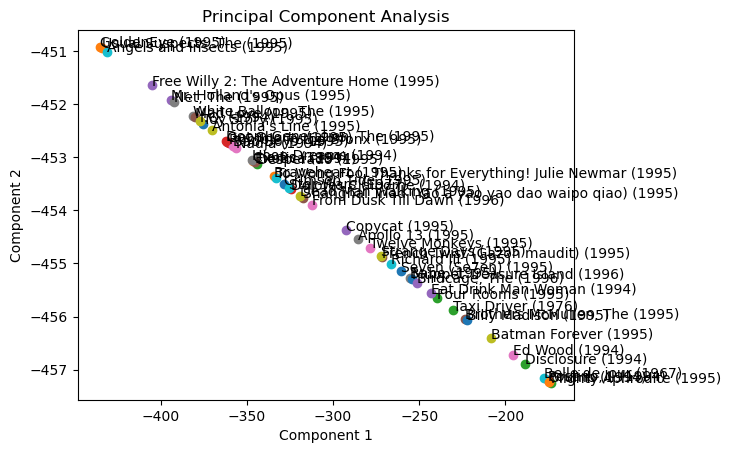

In [41]:
for i in range(50):
    plt.plot(comp1[i], comp2[i], 'o')
    plt.annotate(movies_data[movies_data.movieid == i+1].title.values[0], [comp1[i], comp2[i]])

plt.ylabel("Component 2")
plt.xlabel("Component 1")
plt.title("Principal Component Analysis")
plt.show()

In [37]:
movies_data[movies_data.movieid == 1].title.values[0]

'Toy Story (1995)'